In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style('darkgrid')
from wordcloud import WordCloud,STOPWORDS
import spacy as sp
import string
import nltk
import re
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
# nlps = sp.load('en')

def RMSE(y,yh):
    return np.sqrt(mean_squared_error(y,yh))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rissu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
d_data =pd.read_csv('drake_data.csv',usecols=['album','lyrics_title','lyrics','track_views'])
d_data.head(4)

album                           lyrics_title  \
0  Certified Lover Boy            Certified Lover Boy* Lyrics   
1  Certified Lover Boy  Like I’m Supposed To/Do Things Lyrics   
2  Certified Lover Boy                      Not Around Lyrics   
3  Certified Lover Boy    In the Cut (Ft. Roddy Ricch) Lyrics   

                                              lyrics track_views  
0  [Verse]\nPut my feelings on ice\nAlways been a...        8.7K  
1  [Verse]\nHands are tied\nSomeone's in my ear f...       38.8K  
2  [Intro]\nYeah, we back\nWassup ladies?\nSwisha...      129.8K  
3  [Intro: Drake]\nAyy, yeah\nPipe this shit up a...       72.1K

In [3]:
preprocessed = d_data.copy()
for col in preprocessed.columns[:-1]:
    preprocessed[col]=preprocessed[col].str.lower()
    
preprocessed.head()

album                           lyrics_title  \
0  certified lover boy            certified lover boy* lyrics   
1  certified lover boy  like i’m supposed to/do things lyrics   
2  certified lover boy                      not around lyrics   
3  certified lover boy    in the cut (ft. roddy ricch) lyrics   
4  certified lover boy  zodiac sign (ft. jessie reyez) lyrics   

                                              lyrics track_views  
0  [verse]\nput my feelings on ice\nalways been a...        8.7K  
1  [verse]\nhands are tied\nsomeone's in my ear f...       38.8K  
2  [intro]\nyeah, we back\nwassup ladies?\nswisha...      129.8K  
3  [intro: drake]\nayy, yeah\npipe this shit up a...       72.1K  
4  [verse 1: drake]\nyou ask how many girls i bee...       54.8K

In [4]:
preprocessed.lyrics_title = preprocessed.lyrics_title.apply(lambda x: x.replace('lyrics',''))
preprocessed['is_demo'] = preprocessed.lyrics_title.apply(lambda x: 1 if x.find('(demo)') != -1 else 0)
preprocessed.lyrics_title = preprocessed.lyrics_title.apply(lambda x: x.replace('(demo)',''))
preprocessed.head()

album                     lyrics_title  \
0  certified lover boy            certified lover boy*    
1  certified lover boy  like i’m supposed to/do things    
2  certified lover boy                      not around    
3  certified lover boy    in the cut (ft. roddy ricch)    
4  certified lover boy  zodiac sign (ft. jessie reyez)    

                                              lyrics track_views  is_demo  
0  [verse]\nput my feelings on ice\nalways been a...        8.7K        0  
1  [verse]\nhands are tied\nsomeone's in my ear f...       38.8K        0  
2  [intro]\nyeah, we back\nwassup ladies?\nswisha...      129.8K        0  
3  [intro: drake]\nayy, yeah\npipe this shit up a...       72.1K        0  
4  [verse 1: drake]\nyou ask how many girls i bee...       54.8K        0

In [5]:
preprocessed[preprocessed['is_demo']==1]

album                            lyrics_title  \
262  unreleased songs                            successful     
271  unreleased songs                  desires  (ft. future)    
272  unreleased songs            from time  (ft. jhené aiko)    
274  unreleased songs         pain 1993  (ft. playboi carti)    
276  unreleased songs                               my love     
280  unreleased songs                too good  (ft. rihanna)    
285  unreleased songs            pop style  (ft. kanye west)    
286  unreleased songs               time flies  (ft. future)    
287  unreleased songs  walk it talk it  by quavo (ft. drake)    
288  unreleased songs         god’s plan  (ft. trippie redd)    

                                                lyrics track_views  is_demo  
262  [intro: drake]\nalright well, um, alright. we....        9.4K        1  
271  [intro: future]\nput that christian dior on a ...        7.7K        1  
272  [intro: jhené aiko]\nwhat's up?\nbeen a minute...       13.1K        1  
274  lyrics from snippets\n\n[chorus: drake & playb...         NaN        1  
276  [verse 1]\ni had an idea in my head\ni picture...         NaN        1  
280  [refrain 1: rihanna]\ni don't know how to talk...         NaN        1  
285  lyrics from cut studio recording\n\n[verse 1: ...         NaN        1  
286  lyrics from snippet\n\n[chorus: drake & future...         NaN        1  
287  [intro: quavo]\nyeah, yeah\n(deko)\nwoah, hold...         NaN        1  
288  [intro: drake]\nthey wishing, they wishing, th...         NaN        1

In [6]:
def extract_feat(s):
    artist = s[s.find("(")+1:s.find(")")]
    if artist.find('ft.') != -1:
        return artist.replace('ft. ','')
    else:
        return 'solo'
    
extract_feat(preprocessed['lyrics_title'][100])

'dvsn & pimp c'

In [7]:
extract_feat(preprocessed['lyrics_title'][0])

'solo'

In [8]:
preprocessed['lyrics_title'][100]

'faithful (ft. dvsn & pimp c) '

In [9]:
def remove_artist(s):
    artist = s[s.find("(")+1:s.find(")")]
    if artist.find('ft.') != -1:
        return s[:s.find("(")]
    else:
        return s
    

In [10]:
remove_artist(preprocessed["lyrics_title"][100])

'faithful '

In [11]:
preprocessed['lyrics_title'][100]

'faithful (ft. dvsn & pimp c) '

In [12]:
preprocessed['featuring'] = preprocessed.lyrics_title.apply(extract_feat)
preprocessed.lyrics_title = preprocessed.lyrics_title.apply(remove_artist)
preprocessed.lyrics_title = preprocessed.lyrics_title.apply(remove_artist)
preprocessed.lyrics_title = preprocessed.lyrics_title.apply(lambda x:re.sub(r'[^\w\s]', '', x) )
preprocessed.head()

album                   lyrics_title  \
0  certified lover boy           certified lover boy    
1  certified lover boy  like im supposed todo things    
2  certified lover boy                    not around    
3  certified lover boy                    in the cut    
4  certified lover boy                   zodiac sign    

                                              lyrics track_views  is_demo  \
0  [verse]\nput my feelings on ice\nalways been a...        8.7K        0   
1  [verse]\nhands are tied\nsomeone's in my ear f...       38.8K        0   
2  [intro]\nyeah, we back\nwassup ladies?\nswisha...      129.8K        0   
3  [intro: drake]\nayy, yeah\npipe this shit up a...       72.1K        0   
4  [verse 1: drake]\nyou ask how many girls i bee...       54.8K        0   

      featuring  
0          solo  
1          solo  
2          solo  
3   roddy ricch  
4  jessie reyez

In [13]:
def view_preprocess(s):
    if type(s)!= float:
        if s[-1]=='K':
            return float(s.replace('K',''))*1000
        if s[-1]=='M':
            return float(s.replace('M',''))*10**6

In [14]:
preprocessed.track_views = preprocessed.track_views.apply(view_preprocess)
preprocessed.head()

album                   lyrics_title  \
0  certified lover boy           certified lover boy    
1  certified lover boy  like im supposed todo things    
2  certified lover boy                    not around    
3  certified lover boy                    in the cut    
4  certified lover boy                   zodiac sign    

                                              lyrics  track_views  is_demo  \
0  [verse]\nput my feelings on ice\nalways been a...       8700.0        0   
1  [verse]\nhands are tied\nsomeone's in my ear f...      38800.0        0   
2  [intro]\nyeah, we back\nwassup ladies?\nswisha...     129800.0        0   
3  [intro: drake]\nayy, yeah\npipe this shit up a...      72100.0        0   
4  [verse 1: drake]\nyou ask how many girls i bee...      54800.0        0   

      featuring  
0          solo  
1          solo  
2          solo  
3   roddy ricch  
4  jessie reyez

In [15]:
preprocessed['number_of_verses']=0
preprocessed['number_of_chorus']=0
preprocessed.loc[preprocessed.lyrics.notna().index,'number_of_verses'] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x:len( re.findall(r'verse',x)))
preprocessed.loc[preprocessed.lyrics.notna().index,'number_of_chorus'] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x:len( re.findall(r'chorus',x)))

In [16]:
preprocessed.head()

album                   lyrics_title  \
0  certified lover boy           certified lover boy    
1  certified lover boy  like im supposed todo things    
2  certified lover boy                    not around    
3  certified lover boy                    in the cut    
4  certified lover boy                   zodiac sign    

                                              lyrics  track_views  is_demo  \
0  [verse]\nput my feelings on ice\nalways been a...       8700.0        0   
1  [verse]\nhands are tied\nsomeone's in my ear f...      38800.0        0   
2  [intro]\nyeah, we back\nwassup ladies?\nswisha...     129800.0        0   
3  [intro: drake]\nayy, yeah\npipe this shit up a...      72100.0        0   
4  [verse 1: drake]\nyou ask how many girls i bee...      54800.0        0   

      featuring  number_of_verses  number_of_chorus  
0          solo               1.0               0.0  
1          solo               1.0               2.0  
2          solo               2.0               3.0  
3   roddy ricch               2.0               2.0  
4  jessie reyez               2.0               0.0

In [17]:
a="Rishav"
a[a.find("i")+1:a.find("v")]

'sha'

In [18]:
preprocessed.loc[preprocessed.lyrics.notna().index,'lyrics'] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x: re.sub(r'\[([^]]*)]','',x))
preprocessed.loc[preprocessed.lyrics.notna().index,'lyrics'] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x: x.replace('\n',' '))
preprocessed.loc[preprocessed.lyrics.notna().index,'lyrics'] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x:re.sub(r'[^\w\s]', '', x))

In [19]:
preprocessed.head()

album                   lyrics_title  \
0  certified lover boy           certified lover boy    
1  certified lover boy  like im supposed todo things    
2  certified lover boy                    not around    
3  certified lover boy                    in the cut    
4  certified lover boy                   zodiac sign    

                                              lyrics  track_views  is_demo  \
0   put my feelings on ice always been a gem cert...       8700.0        0   
1   hands are tied someones in my ear from the ot...      38800.0        0   
2   yeah we back wassup ladies swishahouse baby w...     129800.0        0   
3   ayy yeah pipe this shit up and i turn this sh...      72100.0        0   
4   you ask how many girls i been with in my life...      54800.0        0   

      featuring  number_of_verses  number_of_chorus  
0          solo               1.0               0.0  
1          solo               1.0               2.0  
2          solo               2.0               3.0  
3   roddy ricch               2.0               2.0  
4  jessie reyez               2.0               0.0

In [20]:

sid = SIA()
preprocessed['lyrics']=preprocessed['lyrics'].astype('str')
preprocessed['sentiments'] = preprocessed['lyrics'].apply(lambda x: sid.polarity_scores(x))
preprocessed['Positive Sentiment']   = preprocessed['sentiments'].apply(lambda x: x['pos']) 
preprocessed['Neutral Sentiment']    = preprocessed['sentiments'].apply(lambda x: x['neu'])
preprocessed['Negative Sentiment']   = preprocessed['sentiments'].apply(lambda x: x['neg'])
preprocessed.head()

album                   lyrics_title  \
0  certified lover boy           certified lover boy    
1  certified lover boy  like im supposed todo things    
2  certified lover boy                    not around    
3  certified lover boy                    in the cut    
4  certified lover boy                   zodiac sign    

                                              lyrics  track_views  is_demo  \
0   put my feelings on ice always been a gem cert...       8700.0        0   
1   hands are tied someones in my ear from the ot...      38800.0        0   
2   yeah we back wassup ladies swishahouse baby w...     129800.0        0   
3   ayy yeah pipe this shit up and i turn this sh...      72100.0        0   
4   you ask how many girls i been with in my life...      54800.0        0   

      featuring  number_of_verses  number_of_chorus  \
0          solo               1.0               0.0   
1          solo               1.0               2.0   
2          solo               2.0               3.0   
3   roddy ricch               2.0               2.0   
4  jessie reyez               2.0               0.0   

                                          sentiments  Positive Sentiment  \
0  {'neg': 0.133, 'neu': 0.708, 'pos': 0.158, 'co...               0.158   
1  {'neg': 0.067, 'neu': 0.79, 'pos': 0.143, 'com...               0.143   
2  {'neg': 0.18, 'neu': 0.751, 'pos': 0.069, 'com...               0.069   
3  {'neg': 0.114, 'neu': 0.714, 'pos': 0.172, 'co...               0.172   
4  {'neg': 0.098, 'neu': 0.723, 'pos': 0.179, 'co...               0.179   

   Neutral Sentiment  Negative Sentiment  
0              0.708               0.133  
1              0.790               0.067  
2              0.751               0.180  
3              0.714               0.114  
4              0.723               0.098

In [21]:
preprocessed.drop(columns=['sentiments'],inplace=True)

preprocessed['# Of Words']= preprocessed['lyrics'].apply(lambda x: len(x.split(' ')))
preprocessed['# Of StopWords']= preprocessed['lyrics'].apply(lambda x: len([word for word in x.split(' ') if word in list(STOPWORDS)]))
preprocessed['Average Word Length']= preprocessed['lyrics'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(STOPWORDS)])))
preprocessed['Average Sentence Length']= preprocessed['lyrics'].apply(lambda x: np.mean(np.array([len(va) for va in x.split('.')])))


preprocessed.head(3)

album                   lyrics_title  \
0  certified lover boy           certified lover boy    
1  certified lover boy  like im supposed todo things    
2  certified lover boy                    not around    

                                              lyrics  track_views  is_demo  \
0   put my feelings on ice always been a gem cert...       8700.0        0   
1   hands are tied someones in my ear from the ot...      38800.0        0   
2   yeah we back wassup ladies swishahouse baby w...     129800.0        0   

  featuring  number_of_verses  number_of_chorus  Positive Sentiment  \
0      solo               1.0               0.0               0.158   
1      solo               1.0               2.0               0.143   
2      solo               2.0               3.0               0.069   

   Neutral Sentiment  Negative Sentiment  # Of Words  # Of StopWords  \
0              0.708               0.133          21               6   
1              0.790               0.067         180              96   
2              0.751               0.180         566             286   

   Average Word Length  Average Sentence Length  
0             5.200000                    113.0  
1             4.535714                    825.0  
2             4.857143                   2691.0

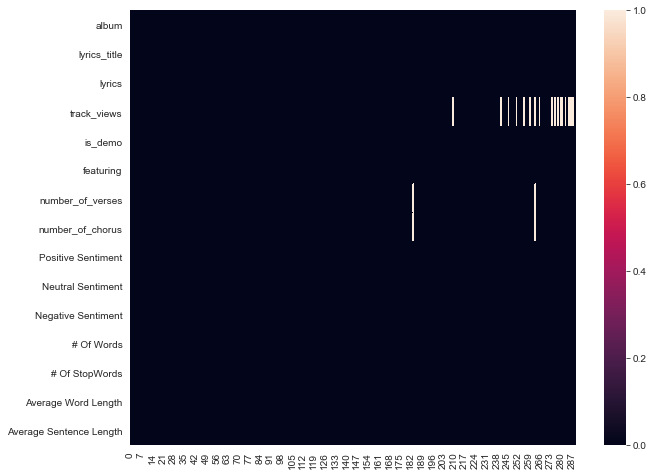

In [22]:
pl.figure(figsize=(10,8))
sns.heatmap(preprocessed.isnull().T)
pl.show()

In [23]:
preprocessed.isna().sum()

album                       0
lyrics_title                0
lyrics                      0
track_views                18
is_demo                     0
featuring                   0
number_of_verses            2
number_of_chorus            2
Positive Sentiment          0
Neutral Sentiment           0
Negative Sentiment          0
# Of Words                  0
# Of StopWords              0
Average Word Length         0
Average Sentence Length     0
dtype: int64

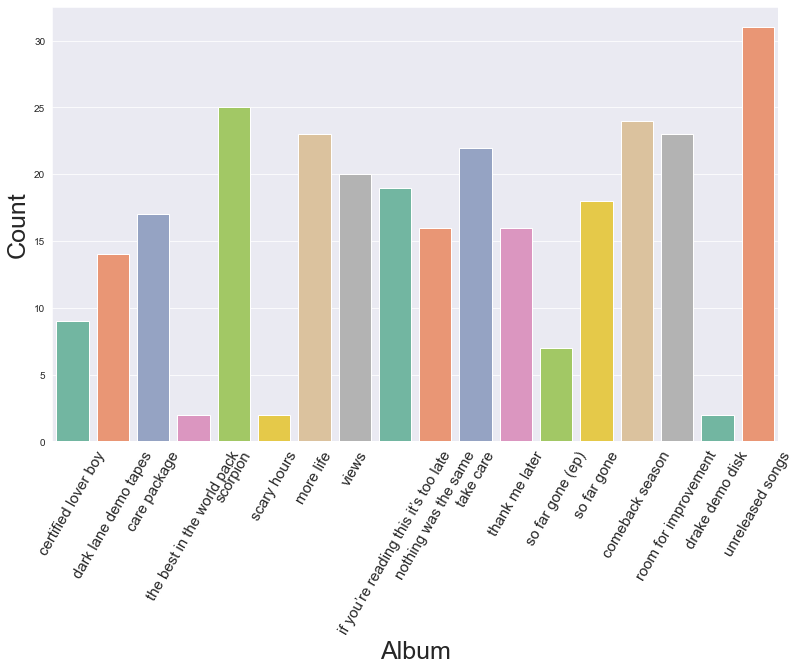

In [24]:
pl.figure(figsize=(13,8))
sns.countplot(preprocessed['album'],palette='Set2')
pl.xticks(rotation=60,fontsize=15)
pl.xlabel("Album",fontsize=25)
pl.ylabel("Count",fontsize=25)
pl.show()

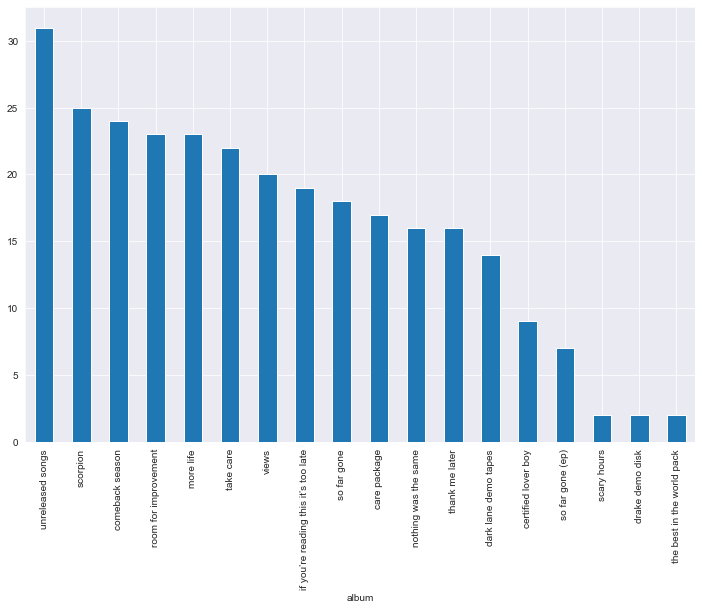

In [25]:
preprocessed.groupby('album')['album'].size().sort_values(ascending=False).plot(kind='bar',figsize=(12,8))

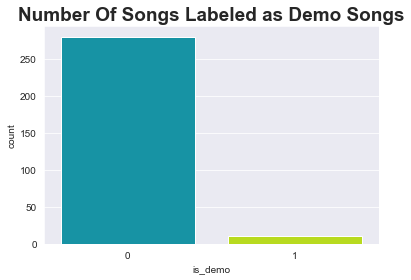

In [26]:
pl.title('Number Of Songs Labeled as Demo Songs',fontsize=19,fontweight='bold')
ax = sns.countplot(preprocessed.is_demo,palette='nipy_spectral')
pl.show()

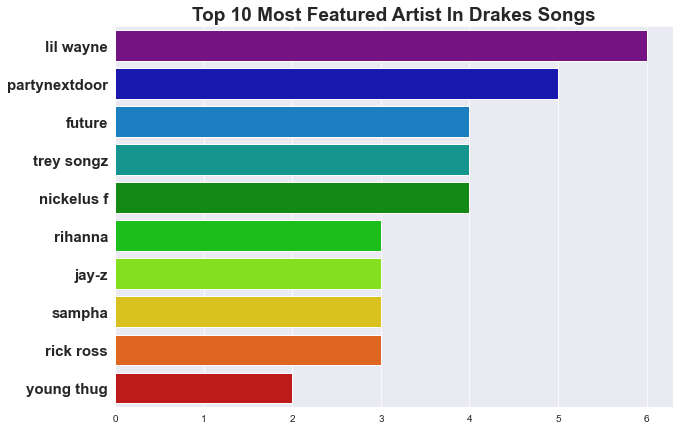

In [27]:
pl.figure(figsize=(10,7))
pl.title('Top 10 Most Featured Artist In Drakes Songs',fontsize=19,fontweight='bold')
ax=sns.barplot(y=preprocessed.featuring.value_counts()[1:11].index,x=preprocessed.featuring.value_counts()[1:11].values,palette='nipy_spectral')
ax.set_yticklabels(ax.get_yticklabels(),fontsize=15,fontweight='bold')
pl.show()

In [28]:
preprocessed.head()

album                   lyrics_title  \
0  certified lover boy           certified lover boy    
1  certified lover boy  like im supposed todo things    
2  certified lover boy                    not around    
3  certified lover boy                    in the cut    
4  certified lover boy                   zodiac sign    

                                              lyrics  track_views  is_demo  \
0   put my feelings on ice always been a gem cert...       8700.0        0   
1   hands are tied someones in my ear from the ot...      38800.0        0   
2   yeah we back wassup ladies swishahouse baby w...     129800.0        0   
3   ayy yeah pipe this shit up and i turn this sh...      72100.0        0   
4   you ask how many girls i been with in my life...      54800.0        0   

      featuring  number_of_verses  number_of_chorus  Positive Sentiment  \
0          solo               1.0               0.0               0.158   
1          solo               1.0               2.0               0.143   
2          solo               2.0               3.0               0.069   
3   roddy ricch               2.0               2.0               0.172   
4  jessie reyez               2.0               0.0               0.179   

   Neutral Sentiment  Negative Sentiment  # Of Words  # Of StopWords  \
0              0.708               0.133          21               6   
1              0.790               0.067         180              96   
2              0.751               0.180         566             286   
3              0.714               0.114         339             169   
4              0.723               0.098         446             236   

   Average Word Length  Average Sentence Length  
0             5.200000                    113.0  
1             4.535714                    825.0  
2             4.857143                   2691.0  
3             4.658824                   1592.0  
4             5.200000                   2206.0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

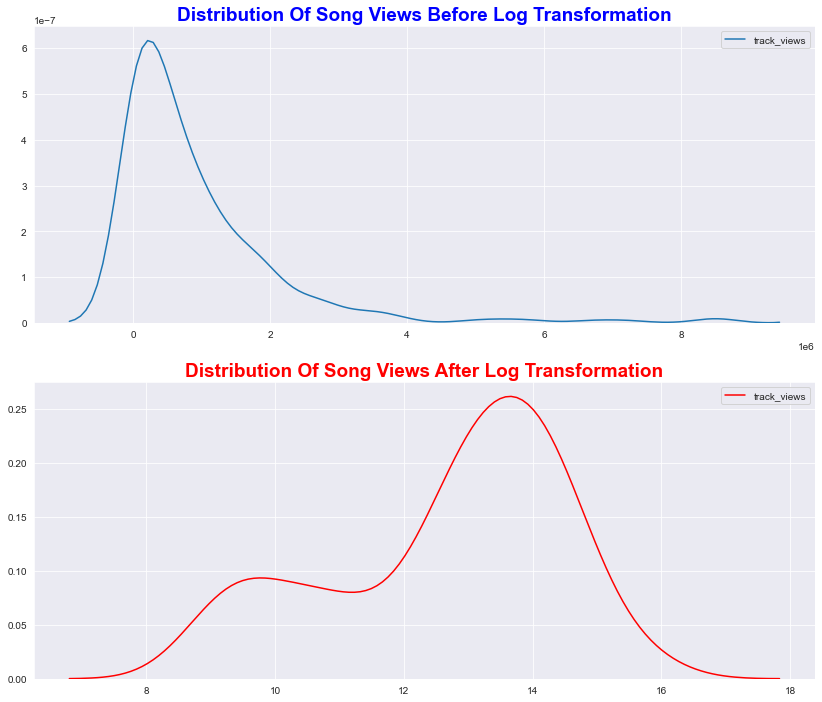

In [29]:
pl.figure(figsize=(14,12))
plt.subplot(2,1,1)
plt.title('Distribution Of Song Views Before Log Transformation',fontsize=19,fontweight='bold',color='b')
sns.kdeplot(preprocessed.track_views)
plt.subplot(2,1,2)
plt.title('Distribution Of Song Views After Log Transformation',fontsize=19,fontweight='bold',color='r')
sns.kdeplot(np.log(preprocessed.track_views),color='r')
plt.show()

<Figure size 1080x720 with 0 Axes>

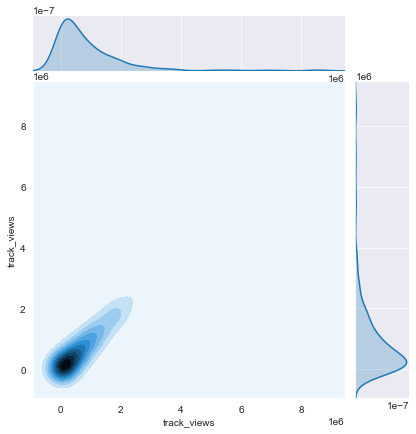

In [30]:
pl.figure(figsize=(15,10))
sns.jointplot(preprocessed.track_views,preprocessed.track_views,kind='kde')
pl.show()

<Figure size 1080x720 with 0 Axes>

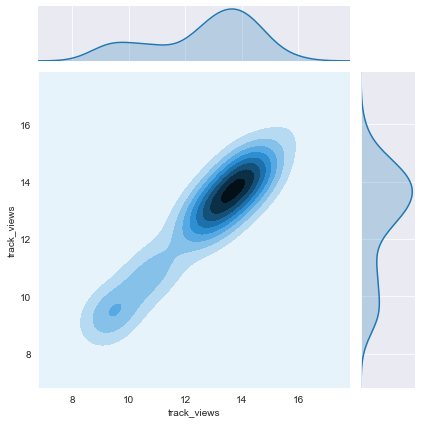

In [31]:
pl.figure(figsize=(15,10))
sns.jointplot(np.log(preprocessed.track_views),np.log(preprocessed.track_views),kind='kde')
pl.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

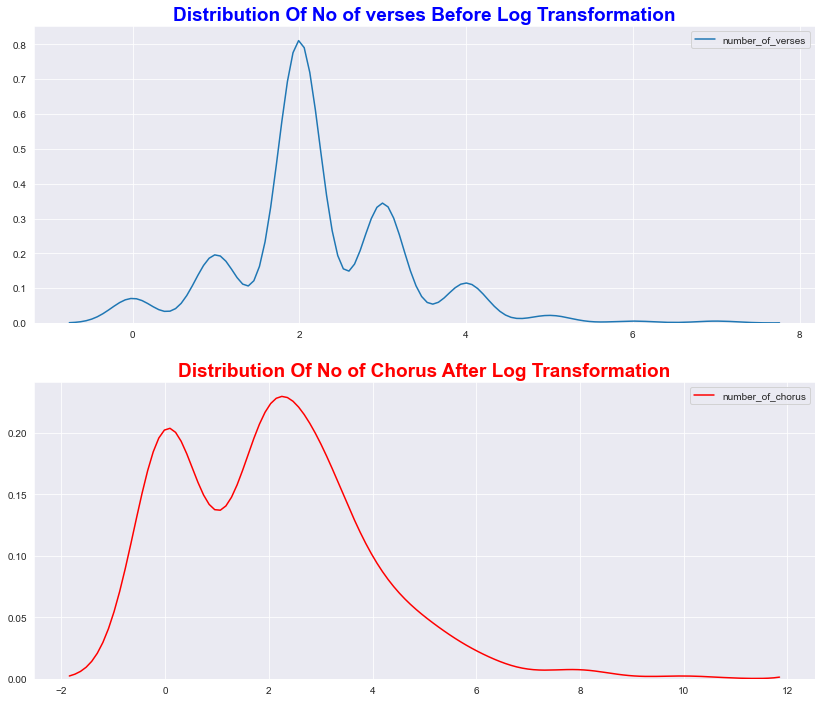

In [32]:
pl.figure(figsize=(14,12))
plt.subplot(2,1,1)
plt.title('Distribution Of No of verses Before Log Transformation',fontsize=19,fontweight='bold',color='b')
sns.kdeplot(preprocessed.number_of_verses)
plt.subplot(2,1,2)
plt.title('Distribution Of No of Chorus After Log Transformation',fontsize=19,fontweight='bold',color='r')
sns.kdeplot(preprocessed.number_of_chorus,color='r')
plt.show()

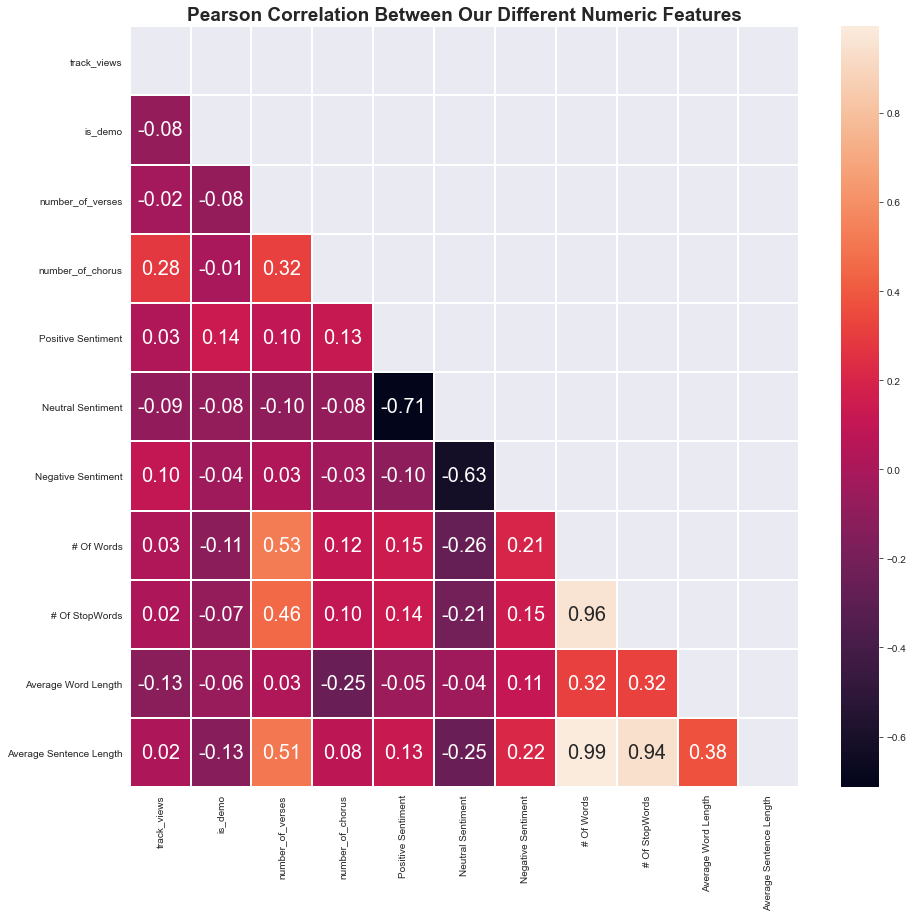

In [33]:
pl.figure(figsize=(15,14))
pl.title('Pearson Correlation Between Our Different Numeric Features',fontsize=19,fontweight='bold')
sns.heatmap(preprocessed.corr(),annot=True,mask=np.triu(np.ones((11,11))),annot_kws={"size": 20},
           linewidth=1,edgecolor='k',fmt='.2f')
pl.show()

certified lover boy  like im supposed todo things  not around  in the cut  zodiac sign  laugh now cr


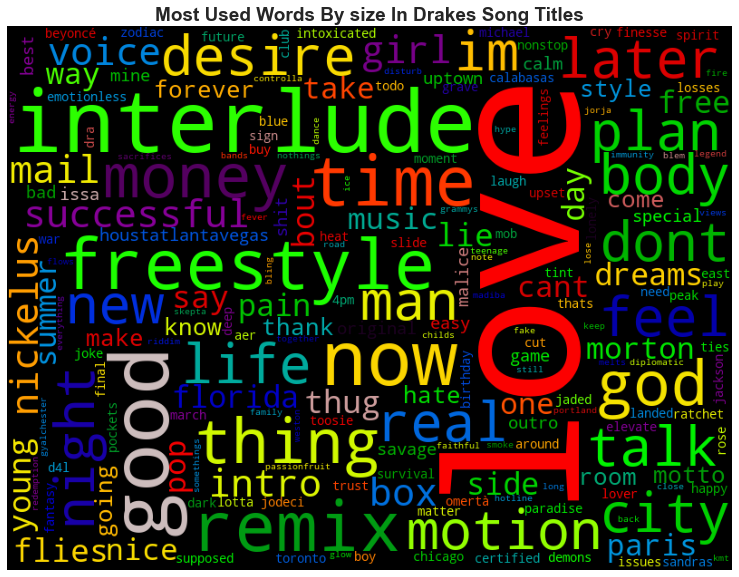

In [34]:
l_t = ' '.join(preprocessed.lyrics_title).strip().replace('drake','')
l_t = l_t.replace('ft','')
print(l_t[:100])
w_c = WordCloud(width=800,height=600,collocations = False,stopwords=STOPWORDS,colormap='nipy_spectral').generate(l_t)
pl.figure(figsize=(14,10))

pl.title('Most Used Words By size In Drakes Song Titles',fontsize=19,fontweight='bold')
pl.imshow(w_c)
pl.axis('off')
pl.show()

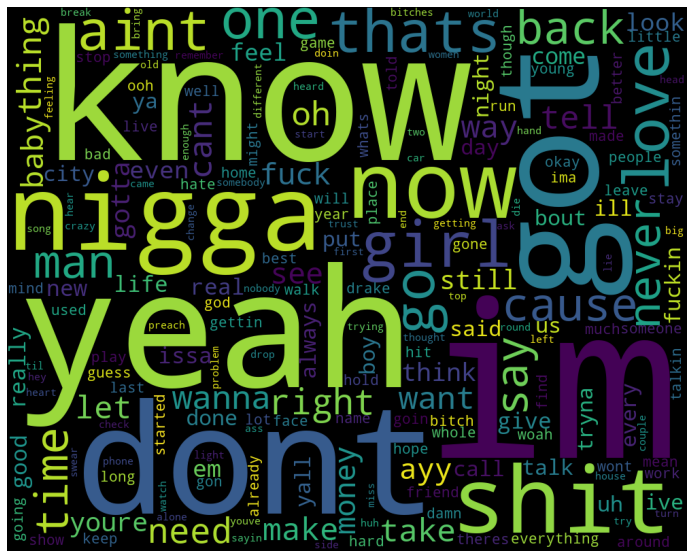

In [35]:
txt=' '.join(preprocessed.lyrics).strip()
pl.figure(figsize=(14,10))
wc=WordCloud(width=1000,height=800,stopwords=STOPWORDS,collocations=False).generate(txt)
pl.axis('off')
pl.imshow(wc)
pl.show()

In [36]:
no_of_components=100
len(preprocessed)

290

In [37]:
x=CountVectorizer().fit_transform(preprocessed.lyrics)
x

<290x8718 sparse matrix of type '<class 'numpy.int64'>'
	with 57335 stored elements in Compressed Sparse Row format>

In [38]:
x.toarray().shape

(290, 8718)

In [39]:
svd=TruncatedSVD(no_of_components)
dec_matrix=svd.fit_transform(x)

In [40]:
dec_matrix.shape

(290, 100)

In [41]:
dec_matrix[:2]

array([[ 5.21785279e-01, -2.29203061e-01, -2.18659758e-01,
         4.09704093e-01, -1.07593916e-01,  7.10913922e-02,
         6.60624364e-01,  8.86553236e-02,  2.57160015e-02,
        -4.36274372e-01,  3.38726061e-01, -1.42634818e-01,
         3.05763186e-01,  1.77178281e-01, -1.88253960e-02,
         3.14396518e-01,  2.75462995e-02,  4.20194781e-02,
         2.73694087e-01,  7.90281588e-02, -4.46232276e-01,
         1.63280651e-01, -1.52942110e-01,  5.25852418e-02,
        -5.43170854e-01,  1.83089183e-01, -3.29783399e-02,
        -1.59890249e-02,  1.92625266e-01, -2.48465806e-01,
        -1.15653575e-01, -2.04264448e-01, -3.94080291e-02,
         3.73136896e-01,  2.82706464e-01,  2.79333046e-02,
         3.54194828e-02, -2.34351668e-01, -1.54718716e-03,
         9.10218919e-02, -1.53477848e-01, -6.75998154e-02,
         7.95706513e-03, -3.51000643e-01, -1.25361710e-01,
        -8.99821831e-02,  2.12349995e-01, -1.37264373e-04,
         1.28683700e-01,  2.46507184e-01, -1.64485384e-0

In [42]:
dec_df=pd.DataFrame(dec_matrix,columns=['PC{}'.format(i) for i in range(no_of_components)])

In [43]:
dec_df.head()

PC0        PC1       PC2       PC3       PC4        PC5       PC6  \
0   0.521785  -0.229203 -0.218660  0.409704 -0.107594   0.071091  0.660624   
1  22.000534  17.978073 -2.968096 -2.496969  0.963423   4.708171 -0.744390   
2  43.907710 -14.222603 -3.989767 -5.146986 -0.456484   0.515097 -2.067406   
3  29.095665 -15.082048 -4.301063 -8.957937  3.764895 -11.905056 -1.523205   
4  34.884141   5.540462 -2.486184  0.845414 -0.863458  -0.496207  0.910448   

        PC7        PC8       PC9  ...      PC90      PC91      PC92      PC93  \
0  0.088655   0.025716 -0.436274  ...  0.134689  0.007464 -0.192224  0.001728   
1  2.906958   3.609326  1.233808  ...  1.497505 -0.371399 -0.076497 -0.061359   
2 -9.994804 -11.939299  0.771516  ... -2.667167  0.298464  8.771860  3.829974   
3  0.988249   6.870095 -1.740826  ... -1.749386  0.280130  1.643018 -1.336870   
4 -2.391335  -4.497887 -0.254537  ... -1.628201  1.106073  0.146957 -0.277249   

       PC94      PC95      PC96      PC97      PC98      PC99  
0  0.040150  0.031553 -0.128894 -0.073134 -0.220645 -0.195638  
1  0.297737 -0.832002 -0.387518 -0.661822  0.568025  0.247000  
2 -0.062367  0.619169 -3.409054 -1.925641  0.664261  4.097804  
3 -1.476407 -0.061787 -1.449890  0.012214 -1.938576 -0.665663  
4  0.046470 -1.042678  0.749750 -0.308982 -0.554366 -0.820314  

[5 rows x 100 columns]

In [44]:
ex_var=svd.explained_variance_ratio_

In [45]:
ex_var

array([0.12719276, 0.07755605, 0.05928134, 0.03880806, 0.0356072 ,
       0.0321014 , 0.02375197, 0.02025677, 0.01939138, 0.01808472,
       0.01550014, 0.01523001, 0.01401483, 0.01341583, 0.01312346,
       0.0127936 , 0.01232719, 0.01201107, 0.01172864, 0.01041771,
       0.00990118, 0.00961939, 0.00876585, 0.008517  , 0.00820106,
       0.00801966, 0.00766383, 0.0075049 , 0.0073941 , 0.00706235,
       0.00681428, 0.00662537, 0.00645246, 0.00624548, 0.00615575,
       0.0059046 , 0.0057165 , 0.00549305, 0.00530123, 0.00512267,
       0.00500496, 0.00488159, 0.00476228, 0.00469215, 0.00455476,
       0.00445499, 0.00420955, 0.00414992, 0.00403866, 0.00390811,
       0.00385469, 0.00377933, 0.00371605, 0.00368567, 0.00351837,
       0.00342914, 0.00336319, 0.00329749, 0.00322534, 0.00314449,
       0.00309976, 0.00301994, 0.00298182, 0.00293971, 0.00286619,
       0.0028062 , 0.00277191, 0.0027166 , 0.00266742, 0.00264959,
       0.00263829, 0.00254742, 0.00247681, 0.00245624, 0.00240

In [46]:
dec_matrix.shape

(290, 100)

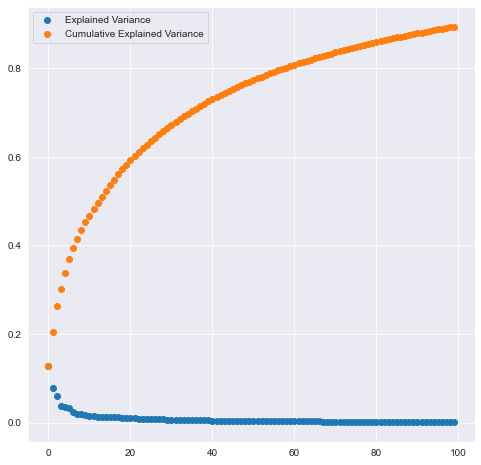

In [47]:
pl.figure(figsize=(8,8))
pl.scatter(np.arange(len(ex_var)),ex_var,label='Explained Variance')
pl.scatter(np.arange(len(ex_var)),np.cumsum(ex_var),label='Cumulative Explained Variance')
pl.legend()
pl.show()

In [48]:
len(ex_var)

100

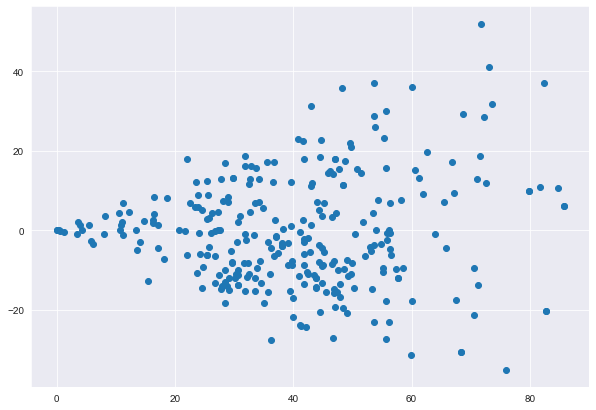

In [49]:
pl.figure(figsize=(10,7))
pl.scatter(dec_df['PC0'],dec_df['PC1'])
pl.show()

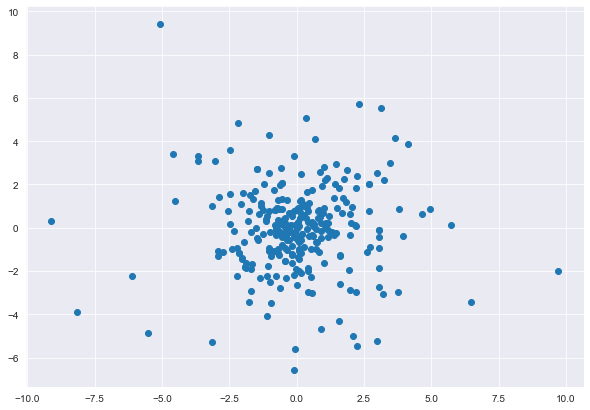

In [50]:
pl.figure(figsize=(10,7))
pl.scatter(dec_df['PC98'],dec_df['PC99'])
pl.show()

In [51]:
np.cov(dec_df['PC98'],dec_df['PC99'])

array([[3.93052692e+00, 9.16697060e-04],
       [9.16697060e-04, 3.87276403e+00]])

In [52]:
np.cov(dec_df['PC0'],dec_df['PC1'])

array([[318.44304483,  22.01305221],
       [ 22.01305221, 194.17129554]])

In [53]:
from sklearn.datasets import make_circles

In [54]:
data=make_circles(50)

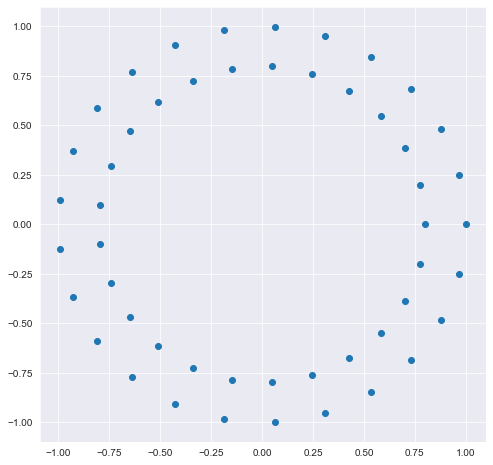

In [55]:
pl.figure(figsize=(8,8))
pl.scatter(data[0][:,0],data[0][:,1])

In [56]:
data1=np.dot(data[0],[[2,3],[1,4]])

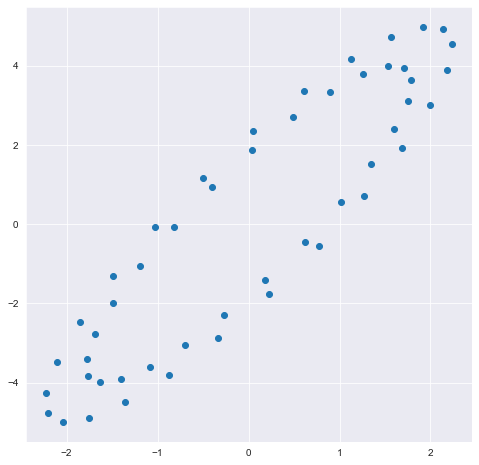

In [57]:
pl.figure(figsize=(8,8))
pl.scatter(data1[:,0],data1[:,1])

In [62]:
album_d = preprocessed.groupby(by='album').mean()
album_d.drop(index='unreleased songs',inplace=True)
album_d['Release_Year'] = 0
album_d.loc['care package','Release_Year']=2019
album_d.loc['certified lover boy','Release_Year']=2021
album_d.loc['comeback season','Release_Year']=2007
album_d.loc['dark lane demo tapes','Release_Year']=2020
album_d.loc['drake demo disk','Release_Year']=2006
album_d.loc['if you’re reading this it’s too late','Release_Year']=2015
album_d.loc['more life','Release_Year']=2017
album_d.loc['nothing was the same','Release_Year']=2013
album_d.loc['room for improvement','Release_Year']=2006
album_d.loc['scary hours','Release_Year']=2018
album_d.loc['scorpion','Release_Year']=2018
album_d.loc['so far gone','Release_Year']=2009
album_d.loc['so far gone (ep)','Release_Year']=2009
album_d.loc['take care','Release_Year']=2011
album_d.loc['thank me later','Release_Year']=2010
album_d.loc['the best in the world pack','Release_Year']=2019
album_d.loc['views','Release_Year']=2016
album_d.head()

track_views  is_demo  number_of_verses  \
album                                                            
care package          925400.000000      0.0          1.941176   
certified lover boy   157233.333333      0.0          1.777778   
comeback season        39417.391304      0.0          2.125000   
dark lane demo tapes  545350.000000      0.0          2.285714   
drake demo disk        39150.000000      0.0          3.000000   

                      number_of_chorus  Positive Sentiment  Neutral Sentiment  \
album                                                                           
care package                  1.941176            0.138941           0.741941   
certified lover boy           2.111111            0.134333           0.745667   
comeback season               0.708333            0.136333           0.751458   
dark lane demo tapes          2.857143            0.149500           0.747286   
drake demo disk               0.000000            0.080500           0.826000   

                      Negative Sentiment  # Of Words  # Of StopWords  \
album                                                                  
care package                    0.119176  567.352941      271.294118   
certified lover boy             0.119778  369.888889      189.444444   
comeback season                 0.112292  566.666667      270.541667   
dark lane demo tapes            0.103143  535.142857      227.714286   
drake demo disk                 0.093500  827.500000      426.000000   

                      Average Word Length  Average Sentence Length  \
album                                                                
care package                     4.498366              2657.000000   
certified lover boy              4.753799              1738.888889   
comeback season                  4.772829              2692.375000   
dark lane demo tapes             4.668456              2581.500000   
drake demo disk                  4.756385              3880.000000   

                      Release_Year  
album                               
care package                  2019  
certified lover boy           2021  
comeback season               2007  
dark lane demo tapes          2020  
drake demo disk               2006

In [68]:
album_mean=album_d.sort_values('Release_Year')
album_mean.head()

track_views  is_demo  number_of_verses  \
album                                                            
room for improvement   23868.421053      0.0          1.913043   
drake demo disk        39150.000000      0.0          3.000000   
comeback season        39417.391304      0.0          2.125000   
so far gone (ep)      434714.285714      0.0          3.285714   
so far gone           269600.000000      0.0          2.555556   

                      number_of_chorus  Positive Sentiment  Neutral Sentiment  \
album                                                                           
room for improvement          0.347826            0.123652           0.794870   
drake demo disk               0.000000            0.080500           0.826000   
comeback season               0.708333            0.136333           0.751458   
so far gone (ep)              3.142857            0.163429           0.733571   
so far gone                   2.277778            0.147611           0.764056   

                      Negative Sentiment  # Of Words  # Of StopWords  \
album                                                                  
room for improvement            0.081478  536.304348      260.130435   
drake demo disk                 0.093500  827.500000      426.000000   
comeback season                 0.112292  566.666667      270.541667   
so far gone (ep)                0.103000  724.428571      354.857143   
so far gone                     0.088278  511.111111      247.055556   

                      Average Word Length  Average Sentence Length  \
album                                                                
room for improvement             4.670247              2560.608696   
drake demo disk                  4.756385              3880.000000   
comeback season                  4.772829              2692.375000   
so far gone (ep)                 4.677964              3371.142857   
so far gone                      4.411586              2385.500000   

                      Release_Year  
album                               
room for improvement          2006  
drake demo disk               2006  
comeback season               2007  
so far gone (ep)              2009  
so far gone                   2009

In [70]:
album_year_index=[album+ " "+str(year) for album,year in zip(album_mean.index,album_mean.Release_Year)]
album_year_index

['room for improvement 2006',
 'drake demo disk 2006',
 'comeback season 2007',
 'so far gone (ep) 2009',
 'so far gone 2009',
 'thank me later 2010',
 'take care 2011',
 'nothing was the same 2013',
 'if you’re reading this it’s too late 2015',
 'views 2016',
 'more life 2017',
 'scorpion 2018',
 'scary hours 2018',
 'the best in the world pack 2019',
 'care package 2019',
 'dark lane demo tapes 2020',
 'certified lover boy 2021']

In [81]:
fig=go.Figure()
fig.add_trace(go.Scatter(
    x=album_year_index,
    y=album_mean['Positive Sentiment'],
    mode='markers+lines',
    name='Mean Positibe Sentiment values'
))
fig.add_trace(go.Scatter(
    x=album_year_index,
    y=album_mean['Negative Sentiment'],
    mode='lines+markers',
    name='Mean Negative Sentiment values'
))
fig.update_layout(title='Distribution of mean positive and negative sentiments')



fig.show()

In [83]:
fig=go.Figure()
fig.add_trace(go.Scatter(
    x=album_year_index,
    y=album_mean['number_of_verses'],
    mode='markers+lines',
    name='Mean verse amount'
))
fig.add_trace(go.Scatter(
    x=album_year_index,
    y=album_mean['number_of_chorus'],
    mode='lines+markers',
    name='Mean chorus amount'
))
fig.update_layout(title="Distribution of mean chorus and verse amount")



fig.show()

In [85]:
fig=go.Figure()
fig.add_trace(go.Scatter(
    x=album_year_index,
    y=album_mean['track_views'],
    mode='markers+lines',
    name='Mean verse amount'
))

fig.update_layout(title="Track views over the years")



fig.show()

In [86]:
preprocessed.columns

Index(['album', 'lyrics_title', 'lyrics', 'track_views', 'is_demo',
       'featuring', 'number_of_verses', 'number_of_chorus',
       'Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment',
       '# Of Words', '# Of StopWords', 'Average Word Length',
       'Average Sentence Length'],
      dtype='object')

In [87]:
preprocessed=preprocessed.reset_index()
Y=preprocessed.loc[preprocessed.track_views.notna(),'track_views']
X=dec_df.iloc[Y.index,:]

In [99]:
rf_pipe=Pipeline(steps=[("RF",RandomForestRegressor(random_state=42))])
LR_Pipe=Pipeline(steps=[("LR",LinearRegression())])
RIDGE_pipe=Pipeline(steps=[("R",Ridge())])


In [109]:
# RF_cross_val_scores=np.sqrt(-1*cross_val_score(rf_pipe,X,Y,cv=5,scoring='neg_mean_squared_error'))
# LR_f1_cross_val_scores=np.sqrt(-1*cross_val_score(LR_Pipe,X,Y,cv=5,scoring='neg_mean_squared_error'))
# Ridge_cross_val_scores=np.sqrt(-1*cross_val_score(RIDGE_pipe,X,Y,cv=5,scoring='neg_mean_squared_error'))


RF_cross_val_scores = np.sqrt(-1*cross_val_score(rf_pipe,X,Y,cv=5,scoring='neg_mean_squared_error'))
LR_f1_cross_val_scores= np.sqrt(-1*cross_val_score(LR_Pipe,X,Y,cv=5,scoring='neg_mean_squared_error'))
Ridge_cross_val_scores= np.sqrt(-1*cross_val_score(RIDGE_pipe,X,Y,cv=5,scoring='neg_mean_squared_error'))

In [110]:
RF_cross_val_scores

array([ 850801.4602732 , 1421322.20640307, 1555992.70073263,
        806623.45268045, 1280053.22206302])

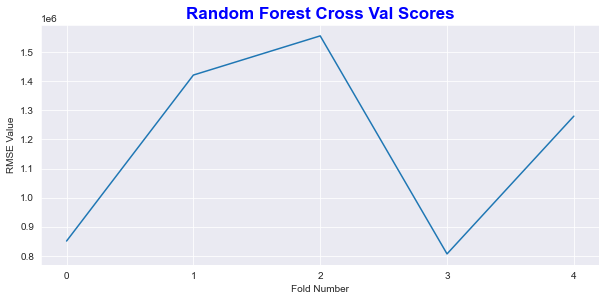

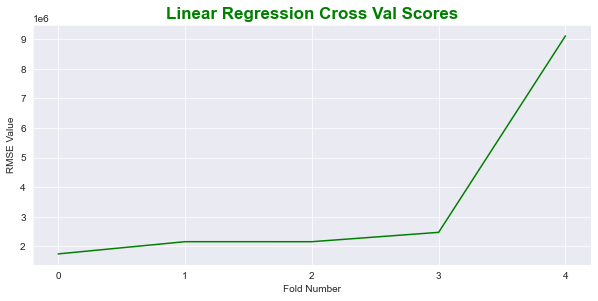

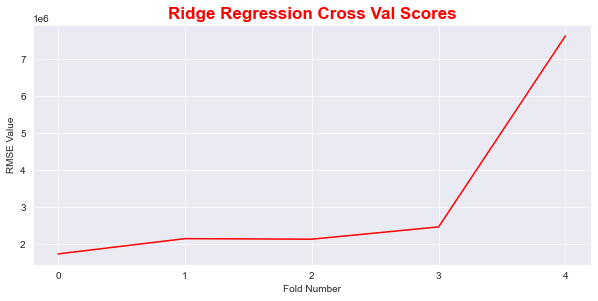

In [111]:
pl.figure(figsize=(10,15))
pl.subplot(3,1,1)
ax = sns.lineplot(x=range(0,len(RF_cross_val_scores)),y=RF_cross_val_scores)
ax.set_title('Random Forest Cross Val Scores',fontsize=17,fontweight='bold',color='b')
ax.set_xticks([i for i in range(0,len(RF_cross_val_scores))])
ax.set_xlabel('Fold Number')
ax.set_ylabel('RMSE Value')
pl.show()

pl.figure(figsize=(10,15))
pl.subplot(3,1,2)
ax = sns.lineplot(x=range(0,len(LR_f1_cross_val_scores)),y=LR_f1_cross_val_scores,color='g')
ax.set_title('Linear Regression Cross Val Scores',fontsize=17,fontweight='bold',color='g')
ax.set_xticks([i for i in range(0,len(LR_f1_cross_val_scores))])
ax.set_xlabel('Fold Number')
ax.set_ylabel('RMSE Value')
pl.show()

pl.figure(figsize=(10,15))
pl.subplot(3,1,3)
ax = sns.lineplot(x=range(0,len(Ridge_cross_val_scores)),y=Ridge_cross_val_scores,color='r')
ax.set_title('Ridge Regression Cross Val Scores',fontsize=17,fontweight='bold',color='r')
ax.set_xticks([i for i in range(0,len(Ridge_cross_val_scores))])
ax.set_xlabel('Fold Number')
ax.set_ylabel('RMSE Value')
pl.show()